# pyfox example


In [1]:
# This cell makes html renders of the notebook have hidden code cells.
# Especially useful for presentations. It does nothing within the
# jupyter lab environment.
from IPython.display import HTML

hide_me = ''
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()">
<input type="submit" id="toggleButton" value="Show Code">
</form>''')

In [2]:
# netcdf/numpy/xray/stats
import numpy as np
import xarray as xr
import yaml

# OS interaction
import os

# import plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import string
import datetime
import pandas as pd
import copy
import btmm_process

# Often there are annoying "divide by zero" warning messages. They are not useful so we ignore them.
import warnings
warnings.filterwarnings("ignore")

## Format plots

In [3]:
%matplotlib inline
# Higher resolution figures within the notebook
# %config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi']= 100

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = 'paper'
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":8})

# Define a default color palette (this should be fairly color blind friendly)
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(sns.color_palette(flatui))

# Define a line style list
ls_list = ['-', '--', ':', '-']
ms_list = ['v', '*', 's', 'o']

alphabet = list(string.ascii_lowercase)

### Directories

- The example notebook assumes that the directory structure is identical to the one found on github.

In [4]:
# DTS data
dir_dts_data = os.getcwd()
experiment_name = 'demo'
dir_data_cal = os.path.join(dir_dts_data, experiment_name, 'calibrated')
dir_data_raw = os.path.join(dir_dts_data, experiment_name, 'raw_netcdf')
dir_data_final = os.path.join(dir_dts_data, experiment_name, 'final')

# Met data
dir_ref_data = os.path.join(dir_dts_data, experiment_name,  'reference_temperature')

#### Load the configuration file

We need to refer to the location library later for mapping the reference sections and evaluating the calibration.

In [5]:
os.chdir(dir_dts_data)

# Read location library
cfg = os.path.join(dir_dts_data, 'example_configuration.yml')
cfg = yaml.load(cfg)
with open(cfg, 'r') as stream:
    cfg = yaml.load(stream)

# For ease of reference the location library is stored in its own dictionary.
phys_locs = cfg['location_library']
# Extract out the reference baths from the mapping library.
#Reference baths MUST be labeled with `calibration` as the `loc_type`.
bath_names = [pl for pl in phys_locs
              if phys_locs[pl]['loc_type'] == 'calibration']

# Finalized dataset

This step can be run after calibrating the FODS data, e.g. within the config file

```python
final_flag = True
```

### Data check - file contents

First, let us see what is in the final datasets. Each "location type" is now its own netcdf.

In [7]:
os.chdir(dir_data_final)
unheat = xr.open_dataset('demo_final_channel 1_20190722-0000_unheated.nc')
print(unheat)

<xarray.Dataset>
Dimensions:   (core: 2, time: 60, xyz: 1630)
Coordinates:
  * xyz       (xyz) int64 0 1 2 3 4 5 6 7 ... 1623 1624 1625 1626 1627 1628 1629
  * time      (time) datetime64[ns] 2019-07-22T00:00:05 ... 2019-07-22T00:05:00
    unheated  (xyz) object ...
  * core      (core) object 'p1' 'p2'
    x         (core, xyz) float64 ...
    y         (core, xyz) float64 ...
    z         (core, xyz) float64 ...
Data variables:
    cal_temp  (core, time, xyz) float64 ...
Attributes:
    dt:       5s
    dLAF:     0.254


The netcdf only contains the calibrated temperature data (`cal_temp`), physical coordinates, time, necessary data attrbiutes, and the data labels for the location type. 

We use a `pandas multiIndex` to label the sparese matrix of physical locations. This datatype has some conveniences, but can also create a headache. It is up to the user to decide if they want to keep the multiIndex.

### Map the data


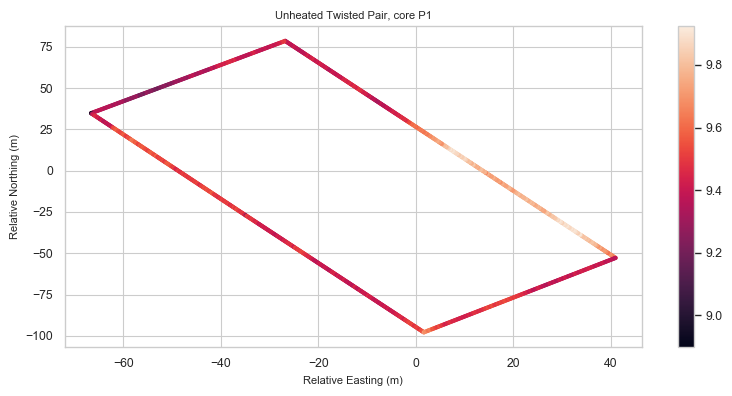

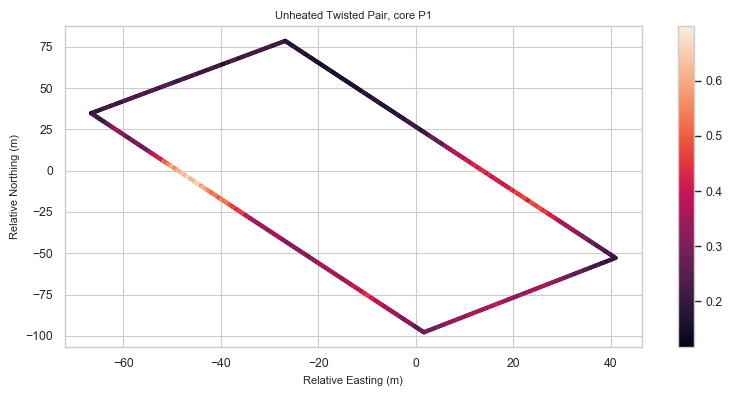

In [8]:
# Time average the data
smpl_data_mean = unheat.sel(core='p1').mean(dim='time')

# Mean
fig, ax = plt.subplots(1, figsize=(8, 4))
ax.set_title('Unheated Twisted Pair, core P1')

# The calibrated temperature data
im = ax.scatter(smpl_data_mean.x, smpl_data_mean.y, 5, smpl_data_mean.cal_temp)

ax.autoscale(enable=True)
ax.set_ylabel('Relative Northing (m)')
ax.set_xlabel('Relative Easting (m)')

fig.colorbar(im)
fig.tight_layout()

# Time average the data
smpl_data_std = unheat.sel(core='p1').std(dim='time')

# Mean
fig, ax = plt.subplots(1, figsize=(8, 4))
ax.set_title('Unheated Twisted Pair, core P1')

# The calibrated temperature data
im = ax.scatter(smpl_data_std.x, smpl_data_std.y, 5, smpl_data_std.cal_temp)

ax.autoscale(enable=True)
ax.set_ylabel('Relative Northing (m)')
ax.set_xlabel('Relative Easting (m)')

fig.colorbar(im)
fig.tight_layout()

Here we plot the calibrated temperature data for core `p1`. We see that the data was in a rectangle.

### Differences between cores

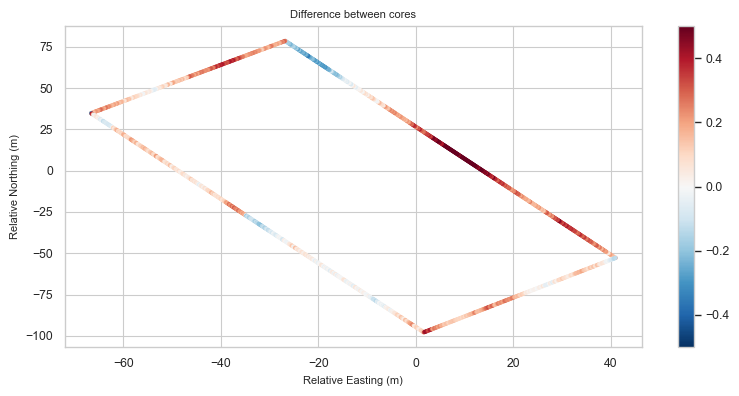

In [9]:
# Mean
fig, ax = plt.subplots(1, figsize=(8, 4))
ax.set_title('Difference between cores')

# The calibrated temperature data
im = ax.scatter(smpl_data_mean.x, smpl_data_mean.y, 5,
                unheat.sel(core='p1').mean(dim='time').cal_temp
                - unheat.sel(core='p2').mean(dim='time').cal_temp,
                cmap=plt.get_cmap('RdBu_r'), vmin=-0.5, vmax=0.5)

ax.autoscale(enable=True)
ax.set_ylabel('Relative Northing (m)')
ax.set_xlabel('Relative Easting (m)')

fig.colorbar(im)
fig.tight_layout()

Some large differences between the cores occur. Why?